<a href="https://colab.research.google.com/github/TheJoys2019/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/Artin_Sinani_DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd
import seaborn as sns
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

import matplotlib.pyplot as plt


train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [6]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


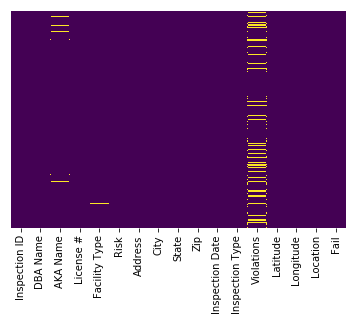

In [7]:
# Get visualization of nulls in data
# This visual shows that we could have major leakage in Violations and secondly in
# AKA Name.
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [8]:
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51916 entries, 0 to 51915
Data columns (total 17 columns):
Inspection ID      51916 non-null int64
DBA Name           51916 non-null object
AKA Name           51293 non-null object
License #          51911 non-null float64
Facility Type      51692 non-null object
Risk               51904 non-null object
Address            51916 non-null object
City               51863 non-null object
State              51906 non-null object
Zip                51890 non-null float64
Inspection Date    51916 non-null object
Inspection Type    51915 non-null object
Violations         42261 non-null object
Latitude           51718 non-null float64
Longitude          51718 non-null float64
Location           51718 non-null object
Fail               51916 non-null int64
dtypes: float64(4), int64(2), object(11)
memory usage: 6.7+ MB


In [10]:
train.describe(include='number')

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,5.191600e+04,5.191100e+04,51890.000000,51718.000000,51718.000000,51916.000000
mean,1.330265e+06,1.549491e+06,60628.834669,41.879568,-87.676663,0.258610
std,6.202664e+05,9.018283e+05,22.736963,0.081126,0.059509,0.437875
min,4.425000e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000
25%,6.796205e+05,1.140745e+06,60614.000000,41.830296,-87.707857,0.000000
50%,1.424226e+06,1.958619e+06,60625.000000,41.890166,-87.666524,0.000000
75%,1.946952e+06,2.215507e+06,60643.000000,41.939167,-87.634461,1.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000


In [11]:
train['Fail'].value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [12]:
"""
Looks like we have a 75% for 0 and 25% for 1. Meaning nearly 75% passed inspection,
25% failed. Which is a pretty significant ratio. 
"""

'\nLooks like we have a 75% for 0 and 25% for 1. Meaning nearly 75% passed inspection,\n25% failed. Which is a pretty significant ratio. \n'

**Part 1: Preprocessing**

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections.

In [13]:
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [14]:
!pip install category_encoders

In [0]:
from sklearn.pipeline import make_pipeline, Pipeline
import category_encoders as ce
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

target = 'Fail'
features = ['Risk', 'Zip', 'Inspection Type','Facility Type']

X_train = train[features]
y_train = train[target]

preprocess = make_pipeline(ce.OrdinalEncoder(), 
                             StandardScaler(), 
                             SimpleImputer())
X_train = preprocess.fit_transform(X_train)

X_train = pd.DataFrame(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)



### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


In [0]:
model = Pipeline(steps=[('preprocess', preprocess),
                       ('boost', XGBClassifier(n_jobs=-1))])

In [24]:
# Fitting a Random Forest Model 
scores = cross_validate(RandomForestClassifier(max_depth=5, n_estimators=100), 
                        X_train, 
                        y_train, 
                        scoring="roc_auc",
                        cv=3, 
                        return_train_score=True, 
                        return_estimator=True)
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,1.521697,0.131961,"(DecisionTreeClassifier(class_weight=None, cri...",0.679765,0.692583
1,1.509481,0.127954,"(DecisionTreeClassifier(class_weight=None, cri...",0.685608,0.691935
2,1.535275,0.132247,"(DecisionTreeClassifier(class_weight=None, cri...",0.689779,0.689461


In [25]:
print("ROC AUC Cross-Valid Score:", scores['test_score'].mean())

ROC AUC Cross-Valid Score: 0.6850506312519015


In [27]:
from sklearn.model_selection import RandomizedSearchCV
# Use random search to find best params
param_distributions = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 5, 6]
}

search = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42),
    param_distributions=param_distributions, 
    n_iter=9, 
    cv=3, 
    scoring="roc_auc", 
    verbose=10, 
    return_train_score=True)

search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] n_estimators=100, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, max_depth=4, score=0.6753720457317349, total=   2.1s
[CV] n_estimators=100, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, score=0.6815144411012946, total=   1.1s
[CV] n_estimators=100, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV]  n_estimators=100, max_depth=4, score=0.6848212421132385, total=   1.1s
[CV] n_estimators=200, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s


[CV]  n_estimators=200, max_depth=4, score=0.6765269015941608, total=   2.2s
[CV] n_estimators=200, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.5s remaining:    0.0s


[CV]  n_estimators=200, max_depth=4, score=0.6821454691126332, total=   2.2s
[CV] n_estimators=200, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.2s remaining:    0.0s


[CV]  n_estimators=200, max_depth=4, score=0.6853867463216885, total=   2.2s
[CV] n_estimators=300, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.8s remaining:    0.0s


[CV]  n_estimators=300, max_depth=4, score=0.6762304734978689, total=   3.2s
[CV] n_estimators=300, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   16.6s remaining:    0.0s


[CV]  n_estimators=300, max_depth=4, score=0.68152696412476, total=   3.2s
[CV] n_estimators=300, max_depth=4 ...................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   20.4s remaining:    0.0s


[CV]  n_estimators=300, max_depth=4, score=0.6844725133568756, total=   3.3s
[CV] n_estimators=100, max_depth=5 ...................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   24.3s remaining:    0.0s


[CV]  n_estimators=100, max_depth=5, score=0.6804475693348853, total=   1.2s
[CV] n_estimators=100, max_depth=5 ...................................
[CV]  n_estimators=100, max_depth=5, score=0.6840820005486443, total=   1.3s
[CV] n_estimators=100, max_depth=5 ...................................
[CV]  n_estimators=100, max_depth=5, score=0.6884404916897808, total=   1.3s
[CV] n_estimators=200, max_depth=5 ...................................
[CV]  n_estimators=200, max_depth=5, score=0.6807195490350546, total=   2.4s
[CV] n_estimators=200, max_depth=5 ...................................
[CV]  n_estimators=200, max_depth=5, score=0.685285682561385, total=   2.3s
[CV] n_estimators=200, max_depth=5 ...................................
[CV]  n_estimators=200, max_depth=5, score=0.688953003827447, total=   2.4s
[CV] n_estimators=300, max_depth=5 ...................................
[CV]  n_estimators=300, max_depth=5, score=0.6804281185809901, total=   3.7s
[CV] n_estimators=300, max_depth=5 ..

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=9, n_jobs=None,
          param_distributions={'n_estimators': [100, 200, 300], 'max_depth': [4, 5, 6]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [0]:
best_val = search.best_score_

In [29]:
best_val

0.6882567560828113

In [0]:
from sklearn.metrics import roc_auc_score
best_estimator = search.best_estimator_

In [39]:
y_pred_proba = best_estimator.predict_proba(X_train.values)[:,1]

print('Test ROC AUC:', roc_auc_score(y_train, y_pred_proba))

Test ROC AUC: 0.6954973572796114


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

In [0]:
# Feature Importances Visualization
feature_importances = pd.Series(best_estimator.steps[1][1].feature_importances_, 
                                X_train.columns)

plt.bar(feature_importances.index, feature_importances.values, color='blue');





### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
 #  Gradient Descent seeks to minimize the cost function/error function created by your model's fit.
- What is the "Learning Rate" and what is its function?
# The Learning Rate is how quickly a gradient descent algo moves toward a local min. It contributes to the identification of the next point for the algo to test it. 
One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._